In [1]:
import yaml
import os
import sys
import random
# sys.path.append('../../')
import numpy as np
from collections import Counter
from omegaconf import OmegaConf
import itertools
from selene_sdk.utils import load_path, parse_configs_and_run
from selene_sdk.utils.config_utils import module_from_dir, module_from_file
from selene_sdk.utils.config import instantiate
from src.dataset import EncodeDataset, LargeRandomSampler, encode_worker_init_fn
from src.transforms import *
from src.utils import interval_from_line
# from torchvision import transforms
# from torchmetrics import BinnedAveragePrecision, AveragePrecision, Accuracy
from tqdm import tqdm
import pandas as pd
import copy
from src.utils import expand_dims
import gc
gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from src.metrics import jaccard_score, threshold_wrapper
from sklearn.metrics import average_precision_score
from selene_sdk.utils.performance_metrics import compute_score

%load_ext autoreload
%autoreload 2

In [13]:
path = 'model_configs/biox_dnase_multi_ct_skf_crossval.yaml'
configs = load_path(path, instantiate=False)
configs['dataset']['debug'] = True
configs['dataset']['loader_args']['batch_size'] = 20

In [37]:
from src.deepct_model_multi_ct import DeepCT

model = DeepCT(**configs['model']['class_args'])

In [15]:
from selene_sdk.utils.config_utils import get_full_dataset, get_full_dataloader

# full_dataset = get_full_dataset(configs)
full_dl = get_full_dataloader(configs)

DEBUG MODE ON: 1000
full_dataloader len: 410


In [6]:
dataset_info = configs["dataset"]

# all intervals
genome_intervals = []
with open(dataset_info["sampling_intervals_path"])  as f:
    for line in f:
        chrom, start, end = interval_from_line(line)
        genome_intervals.append((chrom, start, end))

# bedug mode
if dataset_info['debug']:
    genome_intervals = random.sample(genome_intervals, k=1000)
    print("DEBUG MODE ON:", len(genome_intervals))

with open(dataset_info["distinct_features_path"]) as f:
    distinct_features = list(map(lambda x: x.rstrip(), f.readlines()))
    
with open(dataset_info["target_features_path"]) as f:
    target_features = list(map(lambda x: x.rstrip(), f.readlines()))

DEBUG MODE ON: 1000


# Стратификация по CT

In [5]:
all_targets_mean = np.load('/home/thurs/DeepCT/results/ct_mean_targets.npy')
print(len(all_targets_mean))

631


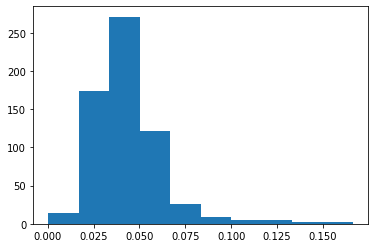

In [6]:
plt.hist(all_targets_mean);

In [7]:
y_cat = pd.cut(all_targets_mean, 10, labels=range(10))
y_cat = np.array(y_cat)

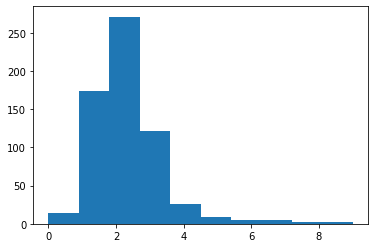

In [8]:
plt.hist(y_cat);

In [11]:
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold

# Stratified k-fold
ct_range = range(configs['model']['class_args']['n_cell_types'])
n_folds = 10
ct_splits = []
ct_values_splits = []
seeds = [1950, 1957, 1962, 1970, 1980, 1989, 2008, 2012, 2017, 2021]
for fold in range(n_folds):
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=seeds[fold])
    tmp = []
    tmp_vals = []
    for train_idx, test_idx in skf.split(ct_range, y_cat):
        tmp.append(test_idx)
        tmp_vals.append((y_cat[train_idx], y_cat[test_idx]))
    ct_splits.append(tmp)
    ct_values_splits.append(tmp_vals)
    
len(ct_splits)

10

In [55]:
[len(c) for c in ct_splits]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [64]:
[(len(c[0]), len(c[1])) for c in ct_values_splits[0]]

[(567, 64),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63),
 (568, 63)]

In [85]:
[(sum(c[0]), sum(c[1])) for c in ct_values_splits[0]]

[(1200, 139),
 (1208, 131),
 (1202, 137),
 (1202, 137),
 (1202, 137),
 (1207, 132),
 (1206, 133),
 (1206, 133),
 (1209, 130),
 (1209, 130)]

In [58]:
# np.save('/home/thurs/DeepCT/results/ct_stratified_ids_k10.npy', ct_splits)

In [3]:
# ct_splits = np.load('/home/thurs/DeepCT/results/ct_stratified_ids_k10.npy', allow_pickle=True)

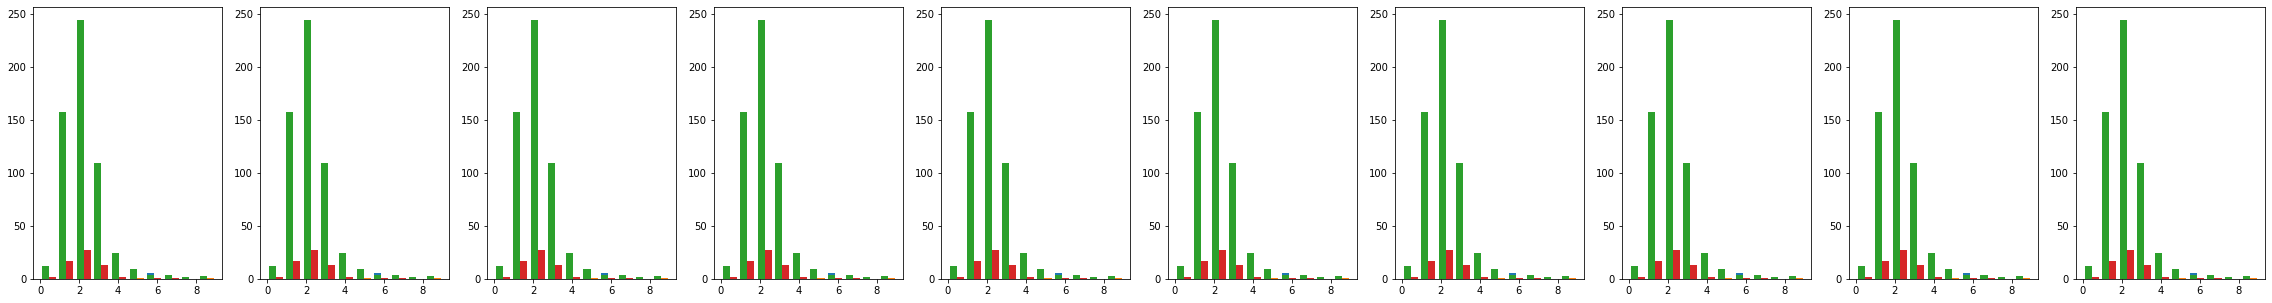

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(40, 5))

for i in range(10):
    axes[i].hist(ct_values_splits[i][0], bins=10)
    axes[i].hist(ct_values_splits[i][1], bins=10)


In [47]:
ct_masks = ct_splits[0]

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001, weight_decay = 1e-6)

for batch in full_dl:
    sequence_batch, cell_type_batch, targets, target_mask = batch

     # val mask
    target_mask_tr = target_mask.clone()
    target_mask_tr[:, ct_masks[0]] = False
    target_mask_val = ~target_mask_tr
    print(target_mask_tr.sum(), target_mask_val.sum())

    # compute a baseline
    baseline = (targets * target_mask_tr).sum(axis=1) / target_mask_tr.sum(axis=1)
    baseline = torch.repeat_interleave(baseline.unsqueeze(1), 631, dim=1)

    with torch.no_grad():
        outputs = model(sequence_batch, cell_type_batch)
        criterion.weight = target_mask_val

        loss = criterion(outputs, targets)
        if criterion.reduction == "sum":
            loss = loss / criterion.weight.sum()

        predictions = torch.sigmoid(outputs)
        predictions = predictions.view(-1, predictions.shape[-1])
        targets = targets.view(-1, targets.shape[-1])
        baseline = baseline.view(-1, baseline.shape[-1])
        target_mask = target_mask_val.view(-1, target_mask_val.shape[-1])

    break

tensor(11340) tensor(1280)


In [44]:
predictions

tensor([[0.4163],
        [0.3897],
        [0.3891],
        ...,
        [0.3596],
        [0.3802],
        [0.3543]])

In [46]:
baseline

tensor([[0.0018],
        [0.0018],
        [0.0018],
        ...,
        [0.0423],
        [0.0423],
        [0.0423]])

In [45]:
targets

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [49]:
# all_predictions = expand_dims(np.concatenate(predictions))
# all_targets = expand_dims(np.concatenate(targets))
# all_baselines = expand_dims(np.concatenate(baseline))
# all_target_masks = expand_dims(np.concatenate(target_mask))

In [ ]:
average_scores = _compute_metrics(
    predictions, targets, target_mask, log_prefix="validation"
)
baselines_scores = _compute_baseline_score(
    baseline, targets, target_mask, log_prefix="validation"
)

# Стратификация по seq

In [25]:
mean_target_np = np.load(f'/home/thurs/DeepCT/results/all_targets_mean.npy')
idx_np = np.load(f'/home/thurs/DeepCT/results/all_idx.npy')

In [27]:
len(mean_target_np), len(idx_np)

(11576175, 11576175)

In [13]:
def create_split_loaders(configs, full_dataset, split):
    """
    Called for each split, this creates a two DataLoaders for each split. 
    One DataLoader for the samples in the training folds and one DataLoader 
    for the samples in the validation fold.
    """
    dataset_info = configs["dataset"]
    # current_fold = configs["dataset"]['dataset_args']['fold']
    # print('current fold:', current_fold)

    train_folds_idx = split[0]
    valid_folds_idx = split[1]
    current_fold_idx = np.append(train_folds_idx, valid_folds_idx)

    train_subset = torch.utils.data.Subset(
        full_dataset, 
        current_fold_idx
        )

    val_subset = torch.utils.data.Subset(
        full_dataset, 
        valid_folds_idx
        )
    val_transform = instantiate(dataset_info["val_transform"])
    val_subset.dataset.transform = val_transform

    module = None
    if os.path.isdir(dataset_info["path"]):
        module = module_from_dir(dataset_info["path"])
    else:
        module = module_from_file(dataset_info["path"])

    train_sampler_class = getattr(module, dataset_info["sampler_class"])
    gen = torch.Generator()
    gen.manual_seed(configs["random_seed"])
    train_sampler = train_sampler_class(
        train_subset, replacement=False, generator=gen
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=dataset_info["loader_args"]["batch_size"],
        num_workers=dataset_info["loader_args"]["num_workers"],
        worker_init_fn=module.subset_encode_worker_init_fn,
        sampler=train_sampler,
    )

    val_sampler_class = getattr(module, dataset_info["validation_sampler_class"])
    gen = torch.Generator()
    gen.manual_seed(configs["random_seed"])

    val_sampler = val_sampler_class(
        data_source=val_subset, 
        num_samples=dataset_info['validation_sampler_args']['num_samples'], 
        generator=gen
    )

    val_loader = torch.utils.data.DataLoader(
            val_subset,
            batch_size=configs['dataset']["loader_args"]["batch_size"],
            num_workers=configs['dataset']["loader_args"]["num_workers"],
            worker_init_fn=module.subset_encode_worker_init_fn,
            sampler=val_sampler,
        )

    return (train_loader, val_loader) 


def get_all_split_loaders(dataset, cv_splits):
    """Create DataLoaders for each split.

    Keyword arguments:
    dataset -- Dataset to sample from.
    cv_splits -- Array containing indices of samples to 
                 be used in each fold for each split.
    aug_count -- Number of variations for each sample in dataset.
    batch_size -- batch size.
    
    """
    split_samplers = []
    
    for i in range(len(cv_splits)):
        split_samplers.append(
            create_split_loaders(
                configs,
                dataset,
                cv_splits[i]
                )
        )
    return split_samplers


In [14]:
train_loader_0, val_loader_0 = create_split_loaders(configs, full_dataset, splits[0])
len(train_loader_0), len(val_loader_0)

(50, 5)

In [15]:
dataloaders = get_all_split_loaders(full_dataset, splits)
len(dataloaders)

10

In [16]:
dataloaders[0]

(<torch.utils.data.dataloader.DataLoader at 0x7fc52b037710>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc52b087d30>)

In [17]:
for i, batch in tqdm(enumerate(dataloaders[0][1])):
    sequence_batch, cell_type_batch, targets, target_mask = batch
    break

0it [00:00, ?it/s]


In [18]:
target_mask.sum()

tensor(12620)

In [19]:
# torch.masked_select(target_mask, torch.tensor(ct_masks[0]))

target_mask_tr = target_mask.clone()
target_mask_tr[:, ct_masks[0].min(): ct_masks[0].max()+1] = False

In [20]:
target_mask_tr.sum()

tensor(11340)

In [44]:
def train(model, batch, fold):
    """
    Trains the model on a batch of data.

    Returns
    -------
    float
        The training loss.

    """    
    # retrieved_seq, cell_type, target, target_mask
    sequence_batch = batch[0]#.to(device)
    cell_type_batch = batch[1]#.to(device)
    targets = batch[2]#.to(device)
    target_mask = batch[3]#.to(device)

    # make train mask
    target_mask_tr = target_mask.clone()
    target_mask_tr[:, ct_masks[fold].min(): ct_masks[fold].max()+1] = False

    outputs = model(sequence_batch, cell_type_batch)

    criterion.weight = target_mask_tr
    loss = criterion(outputs, targets)
    if criterion.reduction == "sum":
        loss = loss / criterion.weight.sum()
    predictions = torch.sigmoid(outputs)

    # predictions = predictions * target_mask_tr
    # targets = targets * target_mask_tr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return (
        predictions.detach().numpy(),
        targets.detach().numpy(),
        target_mask_tr.numpy(),
        loss.item(),
    )

def evaluate(model, batch, target_mask_tr):
    """
    Makes predictions for some labeled input data.

    Parameters
    ----------
    data_in_batches : list(SamplesBatch)
        A list of tuples of the data, where the first element is
        the example, and the second element is the label.

    Returns
    -------
    tuple(float, list(numpy.ndarray))
        Returns the average loss, and the list of all predictions.

    """

    sequence_batch = batch[0]#.to(device)
    cell_type_batch = batch[1]#.to(device)
    targets = batch[2]#.to(device)
    target_mask = batch[3]#.to(device)
    # print('targets', targets.shape)

    # val mask
    target_mask_val = target_mask.clone()
    target_mask_val = ~target_mask_tr

    if target_mask_val.shape[0] != targets.shape[0]:
        target_mask_val = target_mask_val[:targets.shape[0], ...]

    # compure a baseline
    baseline = (targets * target_mask_val).sum(axis=1) / target_mask_val.sum(axis=1)
    baseline = torch.repeat_interleave(baseline.unsqueeze(1), 631, dim=1)

    with torch.no_grad():
        outputs = model(sequence_batch, cell_type_batch)

        criterion.weight = target_mask_val
        loss = criterion(outputs, targets)
        if criterion.reduction == "sum":
            loss = loss / criterion.weight.sum()

        predictions = torch.sigmoid(outputs)
        predictions = predictions.view(-1, predictions.shape[-1])
        targets = targets.view(-1, targets.shape[-1])
        baseline = baseline.view(-1, baseline.shape[-1])
        target_mask = target_mask_val.view(-1, target_mask_val.shape[-1])

    return loss, predictions, targets, baseline, target_mask


In [22]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001, weight_decay = 1e-6)

In [37]:
from selene_sdk.utils import (
    PerformanceMetrics,
    initialize_logger,
    load_model_from_state_dict,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    confusion_matrix,
    roc_auc_score,
)


metrics=dict(roc_auc=roc_auc_score, average_precision=average_precision_score)

_test_metrics = PerformanceMetrics(
            lambda idx: train_batch_loader.dataset.dataset.target_features[idx],
            report_gt_feature_n_positives=10,
            metrics=metrics,
        )

print(train_batch_loader.dataset.dataset.target_features[0])


DNase-seq


In [48]:
# train_batch_loader -- batches all samples in training folds.
# valid_batch_loader -- batches all samples in validation fold.
for fold, (train_batch_loader, valid_batch_loader) in enumerate(dataloaders):
    print('fold:', fold, len(train_batch_loader), len(valid_batch_loader))
    # Loop through all batches in training folds for a given split.
    model.train()
    tain_losses = []
    for batch in tqdm(train_batch_loader):
        # Train model on the training folds in the split.
        prediction, target, target_mask, loss = train(model, batch, fold)
        tain_losses.append(loss)
    print('train loss:', np.average(tain_losses))

    # Loop through all batches in validation fold for a given split.
    model.eval()
    batch_losses = []
    all_predictions = []
    all_targets = []
    all_target_masks = []
    all_baselines = []
    for batch in tqdm(valid_batch_loader):
        # Test model on the validation fold in the split.
        (
            loss,
            predictions,
            targets,
            baseline,
            target_masks,
        ) = evaluate(model, batch, target_mask_tr)

        all_predictions.append(predictions.data.numpy())
        all_targets.append(targets.data.numpy())
        all_target_masks.append(target_masks.data.numpy())
        all_baselines.append(baseline.data.numpy())
        batch_losses.append(loss.item())

    all_predictions = expand_dims(np.concatenate(all_predictions))
    all_targets = expand_dims(np.concatenate(all_targets))
    all_baselines = expand_dims(np.concatenate(all_baselines))
    all_target_masks = expand_dims(np.concatenate(all_target_masks))

    # compute metrics
    average_scores = _test_metrics.update(
        all_predictions, all_targets, all_target_masks
    )
    baseline_score = _test_metrics.update(
        all_baselines, all_targets, all_target_masks
    )

    for name, score in average_scores.items():
        print(name, score)
    for name, score in baseline_score.items():
        print(f'baseline_{name}', score)   


fold: 0 50 5


  8%|▊         | 4/50 [00:28<05:16,  6.88s/it]

In [ ]:
# Stratified k-fold

n_folds = 10
skf = StratifiedKFold(n_folds, shuffle=True, random_state=666)

splits = []
for train_idx, test_idx in k_fold.split(genome_intervals):
    splits.append((train_idx, test_idx))

ct_masks = np.array_split(range(configs['model']['class_args']['n_cell_types']), n_folds)
print([len(c) for c in ct_masks])

In [ ]:
all_targets_mean = np.load('/home/thurs/DeepCT/results/all_targets_mean.npy')